# Nonparametric Analysis
---
*Nonparametric, distribution-free analysis and confidence intervals for tuning curves*

See [**Formalizing the Problem**](./formalizing-the-problem.ipynb) for notation and definitions. For more discussion, see our paper: [**Show Your Work with Confidence: Confidence Bands for Tuning Curves**](https://arxiv.org/abs/2311.09480).

In [1]:
# imports

from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from opda.nonparametric import EmpiricalDistribution
from experiments.simulation import make_damped_linear_sin, Simulation
from opda.utils import beta_highest_density_interval, beta_equal_tailed_interval


# constants

confidence = 0.80


# Configure environment.

np.random.seed(0)


# Configure Matplotlib.

plt.style.use('experiments.default')

## Point Estimates

The literature offers several point estimators for the expected tuning curve, $\tau_e(k) = \mathbb{E}[T_k]$:

- **Naive** The cumulative maximum from the first $k$ samples:

  $$\hat{\tau}_e(k) = \max_{1\leq i \leq k} Y_i$$

- **$V$ Statistic [(Dodge et al., 2019)](https://aclanthology.org/D19-1224/)** The expectation of the cumulative maximum over resampling with replacement:

  $$\hat{\tau}_e(k) = \sum_{i=1}^n Y_{(i)}\left[\left(\frac{i}{n}\right)^k - \left(\frac{i-1}{n}\right)^k\right]$$

- **$U$ Statistic [(Tang et al., 2020)](https://aclanthology.org/2020.acl-main.246/)** The expectation of the cumulative maximum over all permutations of the data:

  $$\hat{\tau}_e(k) = \sum_{i=1}^n Y_{(i)}\left[\frac{\binom{i}{k}}{\binom{n}{k}} - \frac{\binom{i-1}{k}}{\binom{n}{k}}\right]$$
  
See [(Dodge et al., 2021)](https://arxiv.org/abs/2110.00613) for discussion.

To assess these point estimators' merits, we can simulate random search,

In [2]:
s = Simulation.run(
    n_trials=10_000,
    n_samples=24,
    n_dims=3,
    func=make_damped_linear_sin(scale=1, weights=[1, 2, 1], bias=0),
    bounds=[(-1, 1)] * 3,
)
grid = np.linspace(s.y_min + 1e-15, s.y_max - 1e-15, num=1_000)

and compare the estimators to the ground truth:

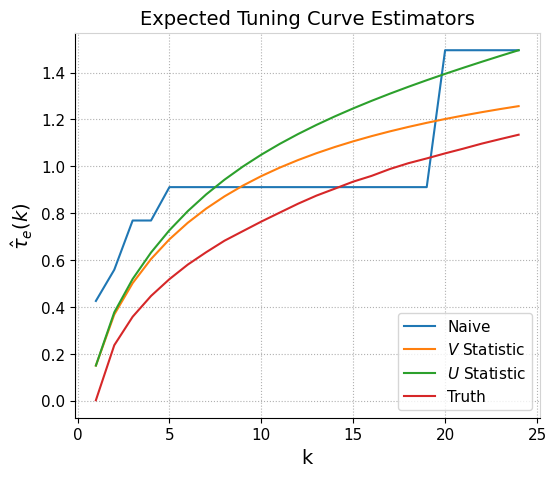

In [3]:
d = EmpiricalDistribution(s.ys)

# Plot different point estimates for the tuning curve.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(s.ns, d.naive_tuning_curve(s.ns), label='Naive')
ax.plot(s.ns, d.v_tuning_curve(s.ns), label='$V$ Statistic')
ax.plot(s.ns, d.u_tuning_curve(s.ns), label='$U$ Statistic')
ax.plot(s.ns, np.mean(s.yss_cummax, axis=0), label='Truth')

# Format the plot.
ax.legend(loc='lower right')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('k')
ax.set_ylabel(r'$\hat{{\tau}}_e(k)$')
ax.set_title('Expected Tuning Curve Estimators')

plt.show()

The naive estimator uses the data inefficiently, with the $U$ and $V$ estimators clearly outperforming it. However, the $U$ and $V$ estimators can disagree substantially and have a lot of noise. Ideally, we'd like confidence bands around the tuning curve so that we know whether our inferences are *reliable* when comparing two models.

## Confidence Bands

As mentioned in [Formalizing the Problem](./formalizing-the-problem.ipynb#Useful-Facts), the CDF for a single iteration of random search, $F$, and for the tuning curve, $F_k$, share a simple algebraic relationship:

$$ F_k(y) = F(y)^k $$

Thus, we can translate confidence bands on $Y$'s CDF into confidence bands on $T_k$'s. If we want a simultaneous confidence band for the whole tuning curve, then the CDF bands must hold simultaneously as well, and not just pointwise.

### Bounding the CDF

[The Dvoretzky-Kiefer-Wolfowitz (DKW) Inequality](https://en.wikipedia.org/wiki/Dvoretzky-Kiefer-Wolfowitz_inequality) provides the standard, asymptotic confidence bound for the CDF:

$$ \mathbb{P}\left(\sup_{y\in\mathbb{R}}|\hat{F}(y) - F(y)| > \epsilon \right) \leq 2e^{-2n\epsilon^2} $$

While the DKW inequality is asymptotically tight, for finite samples the bound can be improved. The quantity:

$$ D_n = \sup_{y\in\mathbb{R}} |\hat{F}(y) - F(y)| $$

is known as the Kolmogorov-Smirnov (KS) statistic. Regardless of the distribution $\mathcal{Y}$, $D_n$ has the Kolmogorov-Smirnov distribution and forms the basis of the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test). By inverting this test, we obtain simultaneous confidence bands for the CDF, essentially tightening the DKW inequality in finite samples.

Let's compare the conservative CDF bands from the DKW inequality to the exact ones from the KS test:

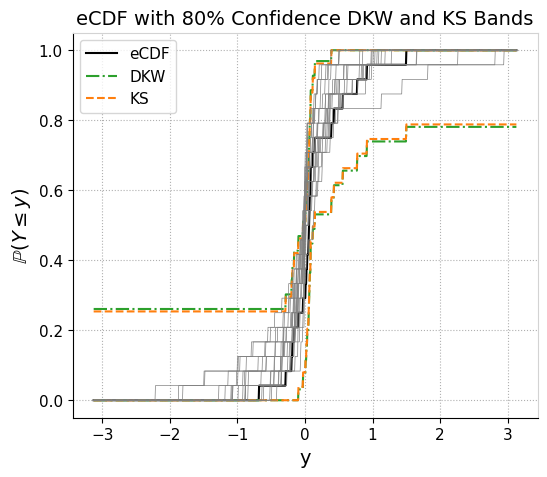

In [4]:
# Construct the CDF confidence bands.
dkw_lower_cdf, point_cdf, dkw_upper_cdf = EmpiricalDistribution.confidence_bands(
    s.ys, confidence=confidence, method='dkw', a=s.y_min, b=s.y_max,
)
ks_lower_cdf, _, ks_upper_cdf = EmpiricalDistribution.confidence_bands(
    s.ys, confidence=confidence, method='ks', a=s.y_min, b=s.y_max,
)

# Plot the CDF confidence bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(grid, point_cdf.cdf(grid),  c='k', linestyle='-', label='eCDF')
ax.plot(grid, dkw_lower_cdf.cdf(grid), c='tab:green', linestyle='-.', label='DKW')
ax.plot(grid, dkw_upper_cdf.cdf(grid), c='tab:green', linestyle='-.')
ax.plot(grid, ks_lower_cdf.cdf(grid), c='tab:orange', linestyle='--', label='KS')
ax.plot(grid, ks_upper_cdf.cdf(grid), c='tab:orange', linestyle='--')

for i in range(1, 21):
    ax.plot(grid, EmpiricalDistribution(s.yss[i, :]).cdf(grid), c='grey', linewidth=0.5)

# Format the plot.
ax.legend()
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('y')
ax.set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')
ax.set_title(f'eCDF with {100 * confidence:.0f}% Confidence DKW and KS Bands')

plt.show()

The DKW and KS bands have uniform width around the eCDF, which makes them convenient but often too wide. In particular, they're violated much more in the middle than on the end points (the area of most interest to us). Tighter bands can be obtained by balancing the violations across all the order statistics [(Learned-Miller and DeStefano, 2005)](http://vis-www.cs.umass.edu/papers/IT_ent_bound.pdf). Since

$$F(Y) \sim U[0, 1]$$

we have:

$$F\left(Y_{(i)}\right) \sim \text{Beta}(i, n - i + 1)$$

Thus, we can create pointwise intervals by:

$$\left[F_{\text{Beta}(i, n-i+1)}^{-1}\left(\frac{1 - \delta}{2}\right), F_{\text{Beta}(i, n-i+1)}^{-1}\left(\frac{1 + \delta}{2}\right)\right]$$

Where $F_{\text{Beta}(i, n-i+1)}^{-1}$ is the Beta's inverse cumulative distribution function and $\delta$ is the coverage. $\delta$ can then be expanded until the overall coverage for the bands is $1 - \alpha$.

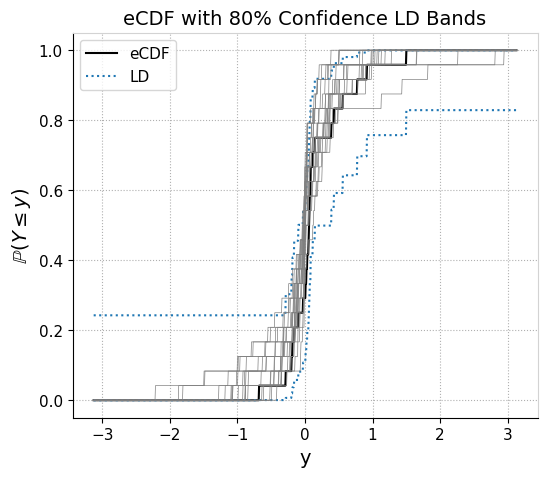

In [5]:
# Construct the CDF confidence bands.
ld_lower_cdf, _, ld_upper_cdf = EmpiricalDistribution.confidence_bands(
    s.ys, confidence=confidence, method='ld_equal_tailed', a=s.y_min, b=s.y_max,
)

# Plot the CDF confidence bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(grid, point_cdf.cdf(grid), c='k', linestyle='-', label='eCDF')
ax.plot(grid, ld_lower_cdf.cdf(grid), c='tab:blue', linestyle=':', label='LD')
ax.plot(grid, ld_upper_cdf.cdf(grid), c='tab:blue', linestyle=':')

for i in range(1, 21):
    ax.plot(grid, EmpiricalDistribution(s.yss[i, :]).cdf(grid), c='grey', linewidth=0.5)

# Format the plot.
ax.legend()
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('y')
ax.set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')
ax.set_title(f'eCDF with {100 * confidence:.0f}% Confidence LD Bands')

plt.show()

Comparing the KS and LD bands, the LD bands are much tighter towards the ends and a bit looser in the middle. This trade off works well for us, since we're interested in the tail of the CDF:

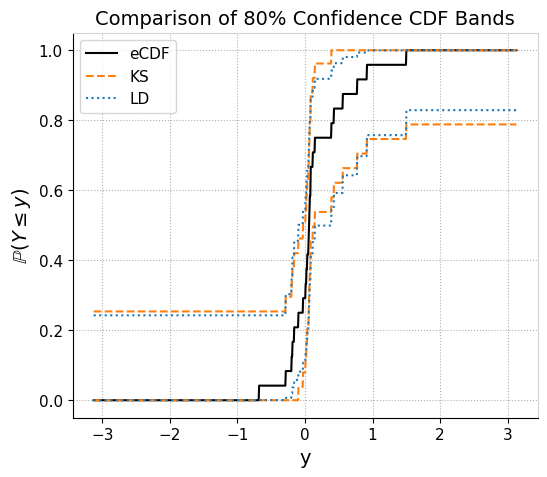

In [6]:
# Plot the CDF confidence band comparison.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(grid, point_cdf.cdf(grid), c='k', linestyle='-', label='eCDF')
ax.plot(grid, ks_lower_cdf.cdf(grid), c='tab:orange', linestyle='--', label='KS')
ax.plot(grid, ks_upper_cdf.cdf(grid), c='tab:orange', linestyle='--')
ax.plot(grid, ld_lower_cdf.cdf(grid), c='tab:blue', linestyle=':', label='LD')
ax.plot(grid, ld_upper_cdf.cdf(grid), c='tab:blue', linestyle=':')

# Format the plot.
ax.legend()
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('y')
ax.set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')
ax.set_title(f'Comparison of {100 * confidence:.0f}% Confidence CDF Bands')

plt.show()

One important detail of the LD bands is how to choose pointwise confidence intervals for the order statistics given that they're Beta distributed. The simplest method, as previously mentioned, is to take the equal-tailed interval based on the quantiles:

$$\left[F_{\text{Beta}(i, n-i+1)}^{-1}\left(\frac{1 - \delta}{2}\right), F_{\text{Beta}(i, n-i+1)}^{-1}\left(\frac{1 + \delta}{2}\right)\right]$$

However, these intervals are larger than necessary. The shortest intervals are obtained from the Beta distribution's *highest probability density* intervals. The two intervals are close in size; however, the HPD intervals can be noticeably shorter for the extreme order statistics:

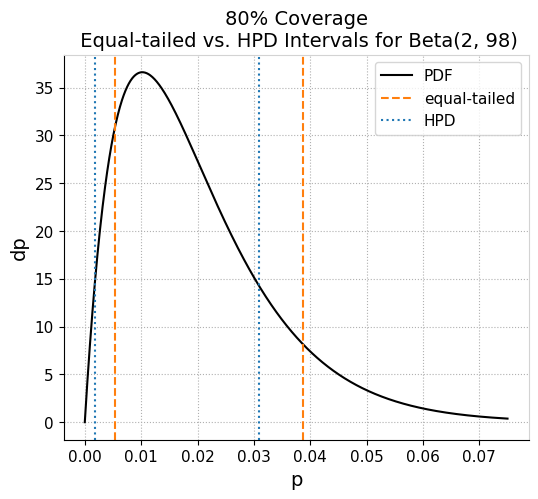

Interval Length Reduction: 12.7%


In [7]:
# Construct the equal-tailed and HPD intervals.
a, b = 2, 98

ps = np.linspace(0, 0.075, num=1_000)
beta = stats.beta(a, b)

lo_equal_tailed, hi_equal_tailed = beta_equal_tailed_interval(a, b, confidence)
lo_highest_density, hi_highest_density = beta_highest_density_interval(a, b, confidence)

# Plot a comparison of the equal-tailed and HPD intervals.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(ps, beta.pdf(ps), c='k', linestyle='-', label='PDF')
ax.axvline(lo_equal_tailed, c='tab:orange', linestyle='--', label='equal-tailed')
ax.axvline(hi_equal_tailed, c='tab:orange', linestyle='--')
ax.axvline(lo_highest_density, c='tab:blue', linestyle=':', label='HPD')
ax.axvline(hi_highest_density, c='tab:blue', linestyle=':')

# Format the plot.
ax.legend()
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('p')
ax.set_ylabel('dp')
ax.set_title(
    f'{100 * confidence:.0f}% Coverage\n'
    f' Equal-tailed vs. HPD Intervals for Beta({a}, {b})'
)

plt.show()

interval_ratio = (hi_highest_density - lo_highest_density) / (hi_equal_tailed - lo_equal_tailed)

print(
    f'Interval Length Reduction: {100 * (1 - interval_ratio):.1f}%'
)

Comparing the CDF bands, the effect is slight but noticeable:

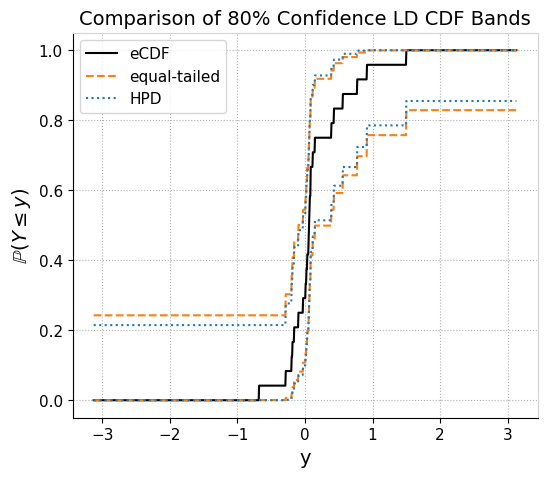

In [8]:
# Construct the CDF confidence bands.
ld_equal_tailed_lower_cdf, _, ld_equal_tailed_upper_cdf = EmpiricalDistribution.confidence_bands(
    s.ys, confidence=confidence, method='ld_equal_tailed', a=s.y_min, b=s.y_max,
)
ld_highest_density_lower_cdf, _, ld_highest_density_upper_cdf = EmpiricalDistribution.confidence_bands(
    s.ys, confidence=confidence, method='ld_highest_density', a=s.y_min, b=s.y_max,
)

# Plot the CDF confidence bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(grid, point_cdf.cdf(grid), c='k', linestyle='-', label='eCDF')
ax.plot(grid, ld_equal_tailed_lower_cdf.cdf(grid), c='tab:orange', linestyle='--', label='equal-tailed')
ax.plot(grid, ld_equal_tailed_upper_cdf.cdf(grid), c='tab:orange', linestyle='--')
ax.plot(grid, ld_highest_density_lower_cdf.cdf(grid), c='tab:blue', linestyle=':', label='HPD')
ax.plot(grid, ld_highest_density_upper_cdf.cdf(grid), c='tab:blue', linestyle=':')

# Format the plot.
ax.legend()
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('y')
ax.set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')
ax.set_title(f'Comparison of {100 * confidence:.0f}% Confidence LD CDF Bands')

plt.show()

It's easier to visualize the benefit as percent reduction in interval width for different values of $Y$:

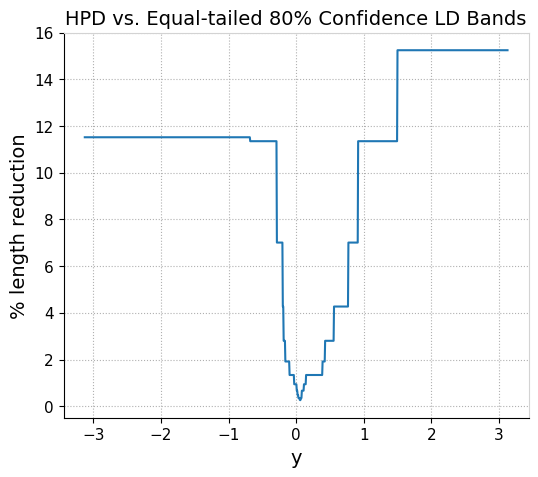

In [9]:
# Plot the percent length reduction from HPD intervals.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

percent_reductions = 100 * (1 - (
    (ld_highest_density_upper_cdf.cdf(grid) - ld_highest_density_lower_cdf.cdf(grid))
    / (ld_equal_tailed_upper_cdf.cdf(grid) - ld_equal_tailed_lower_cdf.cdf(grid))
))
ax.plot(grid, percent_reductions)

# Format the plot.
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('y')
ax.set_ylabel('% length reduction')
ax.set_title(f'HPD vs. Equal-tailed {100 * confidence:.0f}% Confidence LD Bands')

plt.show()

### Bounding the Tuning Curve

Now that we have bounds for the CDF, the next step is to translate them to the tuning curve. Since the CDF bands place all probability mass on the order statistics, we can use a modification of the *$V$ Statistic* formula to convert them to expected tuning curves:

$$\hat{\tau}_e(k) = \sum_{i=0}^{n+1} Y_{(i)}\left(\hat{F}\left(Y_{(i)}\right)^k - \hat{F}\left(Y_{(i-1)}\right)^k\right)$$

Where $\hat{F}$ is the appropriate CDF bound or estimate, $Y_{(0)}$ and $Y_{(n+1)}$ are respectively (possibly infinite) lower and upper bounds on $Y$, and $\hat{F}\left(Y_{(-1)}\right)$ is zero by convention.

When the CDF band doesn't have $\hat{F}\left(Y_{(n)}\right) = 1$, then the rest of the probability mass is assigned to $Y$'s upper bound. If the upper bound is infinite, then that probability mass could be distributed across arbitrarily large numbers. Thus, to meaningfully bound the expected tuning curve, we generally need a bound on $Y$'s support.

Let's compare how the different CDF bands bound the expected tuning curves:

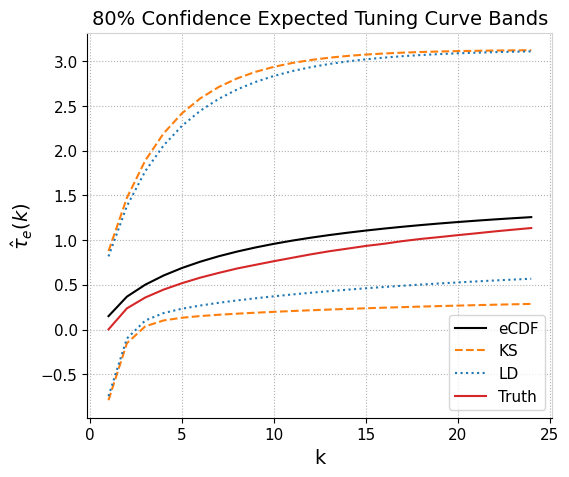

In [10]:
# Plot the expected tuning curve bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(
    s.ns,
    point_cdf.average_tuning_curve(s.ns),
    c='k',
    linestyle='-',
    label='eCDF',
)
ax.plot(
    s.ns,
    ks_lower_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
    label='KS',
)
ax.plot(
    s.ns,
    ks_upper_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
)
ax.plot(
    s.ns,
    ld_lower_cdf.average_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
    label='LD',
)
ax.plot(
    s.ns,
    ld_upper_cdf.average_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
)
ax.plot(
    s.ns, 
    np.mean(s.yss_cummax, axis=0),
    c='tab:red',
    linestyle='-',
    label='Truth',
)

# Format the plot.
ax.legend()
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xlabel('k')
ax.set_ylabel(r'$\hat{{\tau}}_e(k)$')
ax.set_title(
    f'{100 * confidence:.0f}% Confidence'
    f' Expected Tuning Curve Bands'
)

plt.show()

Sometimes, reasonable bounds on performance are not available. Unlike the expected tuning curve, the *median* tuning curve, $\tau_m(k) = \mathbb{M}[T_k]$ (where $\mathbb{M}[X]$ denotes the median of $X$), doesn't require good bounds to create confidence bands. We can compute the median tuning curve by inverting the CDF:

$$F_k(y) = 0.5 \implies y = F_k^{-1}(0.5)$$

Confidence bands still exist for *part* of the median tuning curve even when the bounds are $\pm \infty$. More generally, the median tuning curve is only sensitive to the bounds at its endpoints. Thus, if the upper bound is infinite, the entire expected tuning curve is ruined but only the right side of the median tuning curve is.

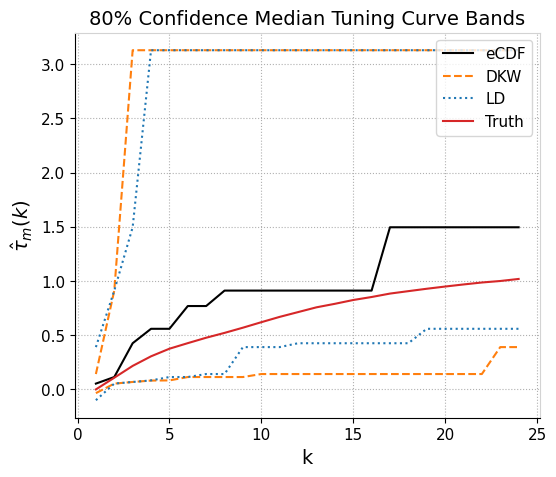

In [11]:
# Plot the quantile tuning curve bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(
    s.ns,
    point_cdf.quantile_tuning_curve(s.ns),
    c='k',
    linestyle='-',
    label='eCDF',
)
ax.plot(
    s.ns,
    dkw_lower_cdf.quantile_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
    label='DKW',
)
ax.plot(
    s.ns,
    dkw_upper_cdf.quantile_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
)
ax.plot(
    s.ns,
    ld_lower_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
    label='LD',
)
ax.plot(
    s.ns,
    ld_upper_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
)
ax.plot(
    s.ns, 
    np.median(s.yss_cummax, axis=0),
    c='tab:red',
    linestyle='-',
    label='Truth',
)

# Format the plot.
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend(loc='upper right')
ax.set_xlabel('k')
ax.set_ylabel(r'$\hat{{\tau}}_m(k)$')
ax.set_title(
    f'{100 * confidence:.0f}% Confidence'
    f' Median Tuning Curve Bands'
)

plt.show()

We compare the expected and median tuning curves below:

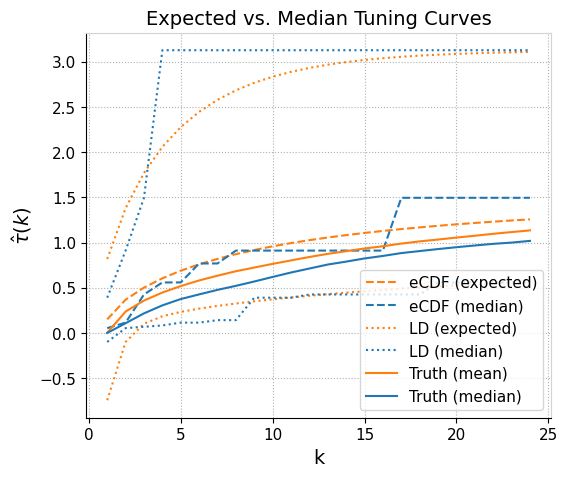

In [12]:
# Plot a comparison of the expected and quantile tuning curves.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(
    s.ns,
    point_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
    label='eCDF (expected)',
)
ax.plot(
    s.ns,
    point_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle='--',
    label='eCDF (median)',
)
ax.plot(
    s.ns,
    ld_lower_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle=':',
    label='LD (expected)',
)
ax.plot(
    s.ns,
    ld_upper_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle=':',
)
ax.plot(
    s.ns,
    ld_lower_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
    label='LD (median)',
)
ax.plot(
    s.ns,
    ld_upper_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
)
ax.plot(
    s.ns, 
    np.mean(s.yss_cummax, axis=0),
    c='tab:orange',
    linestyle='-',
    label='Truth (mean)',
)
ax.plot(
    s.ns, 
    np.median(s.yss_cummax, axis=0),
    c='tab:blue',
    linestyle='-',
    label='Truth (median)',
)

# Format the plot.
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend(loc='lower right')
ax.set_xlabel('k')
ax.set_ylabel(r'$\hat{{\tau}}(k)$')
ax.set_title('Expected vs. Median Tuning Curves')

plt.show()

If we use looser bounds on $Y$ ($\pm \infty$), then the median curves still exist while the expected ones are vacuous:

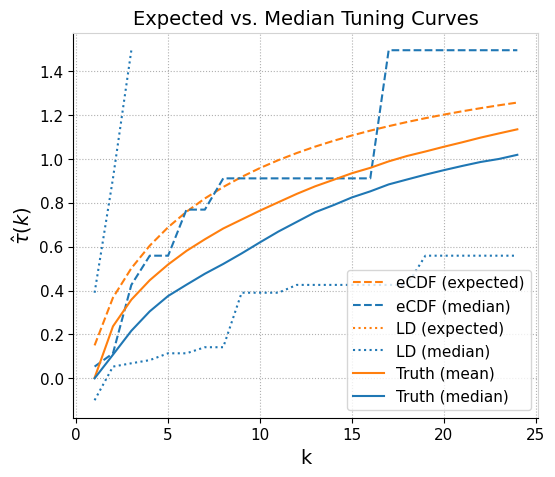

In [13]:
# Construct the equal-tailed CDF bands.
ld_lower_cdf, point_cdf, ld_upper_cdf = EmpiricalDistribution.confidence_bands(
    s.ys, confidence=confidence, method='ld_equal_tailed', a=-np.inf, b=np.inf,
)

# Plot a comparison of the expected and quantile tuning curves.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(
    s.ns,
    point_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
    label='eCDF (expected)',
)
ax.plot(
    s.ns,
    point_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle='--',
    label='eCDF (median)',
)
ax.plot(
    s.ns,
    ld_lower_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle=':',
    label='LD (expected)',
)
ax.plot(
    s.ns,
    ld_upper_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle=':',
)
ax.plot(
    s.ns,
    ld_lower_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
    label='LD (median)',
)
ax.plot(
    s.ns,
    ld_upper_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
)
ax.plot(
    s.ns, 
    np.mean(s.yss_cummax, axis=0),
    c='tab:orange',
    linestyle='-',
    label='Truth (mean)',
)
ax.plot(
    s.ns, 
    np.median(s.yss_cummax, axis=0),
    c='tab:blue',
    linestyle='-',
    label='Truth (median)',
)

# Format the plot.
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend(loc='lower right')
ax.set_xlabel('k')
ax.set_ylabel(r'$\hat{{\tau}}(k)$')
ax.set_title('Expected vs. Median Tuning Curves')

plt.show()

Now that we know how to translate CDF bounds to tuning curves, let's see how much of an impact the HPD interval makes over the equal-tailed interval for the LD bands:

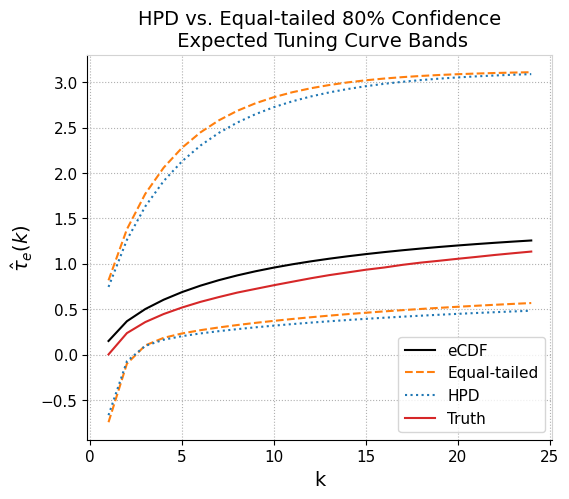

In [14]:
# Plot a comparison of the equal-tailed and HPD tuning curve bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(
    s.ns,
    point_cdf.average_tuning_curve(s.ns),
    c='k',
    linestyle='-',
    label='eCDF',
)
ax.plot(
    s.ns,
    ld_equal_tailed_lower_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
    label='Equal-tailed',
)
ax.plot(
    s.ns,
    ld_equal_tailed_upper_cdf.average_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
)
ax.plot(
    s.ns,
    ld_highest_density_lower_cdf.average_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
    label='HPD',
)
ax.plot(
    s.ns,
    ld_highest_density_upper_cdf.average_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
)
ax.plot(
    s.ns,
    np.mean(s.yss_cummax, axis=0),
    c='tab:red',
    linestyle='-',
    label='Truth',
)

# Format the plot.
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel(r'$\hat{{\tau}}_e(k)$')
ax.set_title(
    f'HPD vs. Equal-tailed {100 * confidence:.0f}% Confidence\n'
    f' Expected Tuning Curve Bands'
)

plt.show()

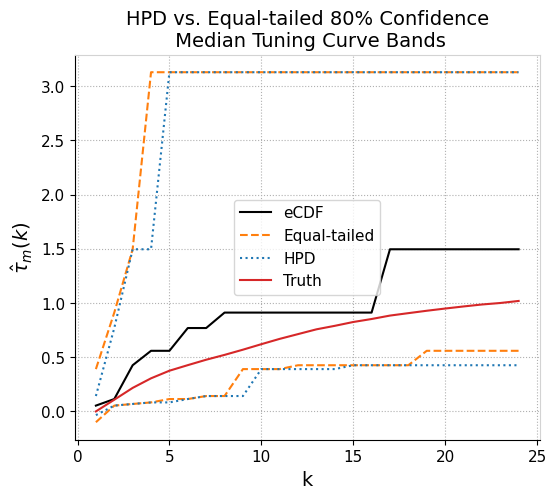

In [15]:
# Plot a comparison of the equal-tailed and HPD tuning curve bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(
    s.ns,
    point_cdf.quantile_tuning_curve(s.ns),
    c='k',
    linestyle='-',
    label='eCDF',
)
ax.plot(
    s.ns,
    ld_equal_tailed_lower_cdf.quantile_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
    label='Equal-tailed',
)
ax.plot(
    s.ns,
    ld_equal_tailed_upper_cdf.quantile_tuning_curve(s.ns),
    c='tab:orange',
    linestyle='--',
)
ax.plot(
    s.ns,
    ld_highest_density_lower_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
    label='HPD',
)
ax.plot(
    s.ns,
    ld_highest_density_upper_cdf.quantile_tuning_curve(s.ns),
    c='tab:blue',
    linestyle=':',
)
ax.plot(
    s.ns,
    np.median(s.yss_cummax, axis=0),
    c='tab:red',
    linestyle='-',
    label='Truth',
)

# Format the plot.
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel(r'$\hat{{\tau}}_m(k)$')
ax.set_title(
    f'HPD vs. Equal-tailed {100 * confidence:.0f}% Confidence\n'
    f' Median Tuning Curve Bands'
)

plt.show()

The effect is slight, but the HPD intervals tighten the upper bound and loosen the lower one. Since the lower band is generally much tighter, we'll take this tradeoff.